In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json

In [2]:
curr_dir=os.getcwd()
grandparent_dir = os.path.abspath(os.path.join(curr_dir, os.pardir,os.pardir))
print(grandparent_dir)
sys.path.append(os.path.join(grandparent_dir))
sys.path.append(os.path.join(grandparent_dir, 'liset_tk'))
print(sys.path)
from liset_tk import liset_tk

from liset_aux import ripples_std, middle


c:\Users\NCN\Documents\PedroFelix\LAVA_SNN_ripples
['c:\\nrn\\lib\\python', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\python39.zip', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\DLLs', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples', '', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib\\site-packages', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib\\site-packages\\win32', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib\\site-packages\\win32\\lib', 'c:\\Users\\NCN\\Miniconda3\\envs\\lava_snn_ripples\\lib\\site-packages\\Pythonwin', 'c:\\Users\\NCN\\Documents\\PedroFelix\\LAVA_SNN_ripples', 'c:\\Users\\NCN\\Documents\\PedroFelix\\LAVA_SNN_ripples\\liset_tk']


No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.5'


In [3]:
parent = r"C:\__NeuroSpark_Liset_Dataset__\neurospark_mat\CNN_TRAINING_SESSIONS" # Modify this to your data path folder

bandpass=[100,250]
downsampled_fs = False # Downsampled frequency
factor=downsampled_fs//1000 if downsampled_fs else 30
time_max=60
window_size=0.05
sample_ratio=0.25
scaling_factor=1
refractory=0

In [4]:
dt=1  # Time step in milliseconds (1 ms)


RIPPLE_DETECTION_OFFSET = [18, 45, 31, 20] # it's calculated as 4.5 periods of the ripple wavelet - for 100 Hz and 250 Hz as the limit frequencies
# The Windows for HFO detection are based on the MAX DETECTION OFFSET

#TODO - Why are these values? Can I tune them in a better way?
RIPPLE_CONFIDENCE_WINDOW = int(round(RIPPLE_DETECTION_OFFSET[1] * 1.8)) 

# in timesteps (ms) - Max time from the Insertion Timing to the GT annotation
MAX_DETECTION_OFFSET = RIPPLE_DETECTION_OFFSET[1]   # in timesteps (ms)

MEAN_DETECTION_OFFSET = RIPPLE_DETECTION_OFFSET[2]   # in timesteps (ms)

WINDOW_SIZE = int(RIPPLE_DETECTION_OFFSET[1]*4)   # in timesteps (ms) - The size of the window to slice the input data

# unit: timesteps (ms) - The number of steps that 2 consecutive windows must overlap to not lose any relevant CBs
# INTERSECT_WINDOW_LEN = int(MAX_DETECTION_OFFSET)
std, mean = ripples_std(parent) # 61 ms # in seconds
INTERSECT_WINDOW_LEN=int((std+mean)*1000) # in timesteps (ms) - The size of the intersection window to slice the input data

# unit: timesteps (ms) - The number of steps that the window must shift to get the next window
WINDOW_SHIFT = int(WINDOW_SIZE - INTERSECT_WINDOW_LEN)

# unit: timesteps (ms) - The time window after the GT annotation where the network should predict the burst (GT_time, GT_time + PRED_CAUSALITY_WINDOW)
# This is needed to give the network some extra time steps to increase the membrane potential and spike
PRED_CAUSALITY_WINDOW = int(5)     # Giving PRED_CAUSALITY_WINDOW ms for the network to update its inner state and spike   

# unit: timesteps (ms) - The time window around the GT annotation where the network should predict the burst (GT_time - PRED_GT_TOLERANCE, GT_time + PRED_GT_TOLERANCE)
PRED_GT_TOLERANCE = int(RIPPLE_DETECTION_OFFSET[3])  # in timesteps (ms)
print(f"WINDOW_SIZE: {WINDOW_SIZE}")
print(f"INTERSECT_WINDOW_LEN: {INTERSECT_WINDOW_LEN} (MEAN+STD)")
print(f"WINDOW_SHIFT: {WINDOW_SHIFT}")
print(f"MEAN DETECTION OFFSET: {MEAN_DETECTION_OFFSET}")
print(f"PRED_GT_TOLERANCE: {PRED_GT_TOLERANCE}")
print(f"PRED_CAUSALITY_WINDOW: {PRED_CAUSALITY_WINDOW}")

WINDOW_SIZE: 180
INTERSECT_WINDOW_LEN: 61 (MEAN+STD)
WINDOW_SHIFT: 119
MEAN DETECTION OFFSET: 31
PRED_GT_TOLERANCE: 20
PRED_CAUSALITY_WINDOW: 5


In [5]:
config = {
    "bandpass": bandpass,
    "downsampled_fs": downsampled_fs,
    "time_max": time_max,
    "window_size": window_size,
    "sample_ratio": sample_ratio,
    "scaling_factor": scaling_factor,
    "refractory": refractory,
    "dt":dt,
    "WINDOW_SHIFT": WINDOW_SHIFT,
    "WINDOW_SIZE": WINDOW_SIZE,
    "INTERSECT_WINDOW_LEN": INTERSECT_WINDOW_LEN,
    "RIPPLE_DETECTION_OFFSET": RIPPLE_DETECTION_OFFSET,
    "PRED_CAUSALITY_WINDOW": PRED_CAUSALITY_WINDOW,
}

In [6]:
from signal_aid import most_active_channel, bandpass_filter


In [7]:
load=False

from extract_Nripples.utils_encoding import *
# Only run this block if first time
if 'windowed_input_dataa' not in locals():
    if load:
        windowed_path=os.path.join(curr_dir,"windowed_data")
        windowed_input_data = np.load(os.path.join(windowed_path,"windowed_input_data.npy"))
        windowed_gt = np.load(os.path.join(windowed_path,"windowed_gt.npy"))
        filtered_windows=np.load(os.path.join(windowed_path,"filtered_windows.npy"))
    else:
        from make_windows import make_windows
        windowed_input_data, windowed_gt, filtered_windows, config=make_windows(parent,config,time_max,downsampled_fs,bandpass,window_size,sample_ratio, scaling_factor, 
                     refractory,WINDOW_SHIFT, WINDOW_SIZE,MEAN_DETECTION_OFFSET,MAX_DETECTION_OFFSET,factor)



data shape:  (71965696, 8)
ripples shape:  (1309, 2)
[WARNING] Spike time 183 is greater than the window size 180. Adjusting...
[WARNING] Window [6343890:6349290] has a GT event at [6347480 6348294] and NO Input activations. Skipping...
[WARNING] Window [18342660:18348060] has a GT event at [18346708 18347944] and NO Input activations. Skipping...
[WARNING] Window [29823780:29829180] has a GT event at [29828768 29830037] and NO Input activations. Skipping...
[WARNING] Window [32594100:32599500] has a GT event at [32597521 32598920] and NO Input activations. Skipping...
[WARNING] Window [33168870:33174270] has a GT event at [33169896 33171361] and NO Input activations. Skipping...
[WARNING] Window [34304130:34309530] has a GT event at [34306773 34308074] and NO Input activations. Skipping...
[WARNING] Window [34961010:34966410] has a GT event at [34965244 34966610] and NO Input activations. Skipping...
[WARNING] Window [34986000:34991400] has a GT event at [34989224 34990721] and NO Inp

In [13]:
up_spikes_per_window = np.sum(windowed_input_data[:, :, 0], axis=1)    # Sum along time axis
down_spikes_per_window = np.sum(windowed_input_data[:, :, 1], axis=1)  # Sum along time axis
print("Up Spikes Total:",np.sum(up_spikes_per_window))
print("Down Spikes Total:",np.sum(down_spikes_per_window))

Up Spikes Total: 1348138
Down Spikes Total: 1356580


In [14]:
# See GT Class Distribution
# Set print options to see more elements
np.set_printoptions(linewidth=100, threshold=50, edgeitems=20)
print(f"Ground Truth Class Distribution: {np.unique(windowed_gt, return_counts=True)}")



GT_HFO_MASK = windowed_gt >= 0
# print(windowed_gt[0:1000])
# Define the number of windows with an HFO
num_hfo_windows = np.sum(GT_HFO_MASK)
print(f"Number of windows with an HFO: {num_hfo_windows}")
print(f"Percentage of windows with an HFO: {num_hfo_windows / windowed_gt.shape[0] * 100:.2f}%")


Ground Truth Class Distribution: (array([-1.000e+00,  3.100e+01,  3.200e+01,  3.300e+01,  3.400e+01,  3.500e+01,  3.600e+01,
        3.700e+01,  3.800e+01,  3.900e+01,  4.000e+01,  4.100e+01,  4.200e+01,  4.300e+01,
        4.400e+01,  4.500e+01,  4.600e+01,  4.700e+01,  4.800e+01,  4.900e+01, ...,  1.710e+02,
        1.720e+02,  1.730e+02,  1.740e+02,  1.750e+02,  1.760e+02,  1.770e+02,  1.780e+02,
        1.790e+02,  1.800e+02,  5.085e+03,  5.150e+03,  5.155e+03,  5.158e+03,  5.202e+03,
        5.246e+03,  5.292e+03,  5.334e+03,  5.336e+03,  5.396e+03], dtype=float32), array([146568,     21,     25,      9,     28,      5,     18,     22,     13,     58,     35,
           22,     33,     28,     23,     52,     58,     49,     29,     72, ...,     25,     54,
           13,     20,      8,      5,     13,     24,     15,      8,      8,      8,      8,
            8,      8,      8,      5,      8,      8,      8], dtype=int64))
Number of windows with an HFO: 9938
Percentage of wind

In [15]:
# Find the indices to sort the input data by the nº of UP/DN spikes (descending order)
sorted_indices = np.argsort(
    -(np.sum(windowed_input_data[:, :, 0], axis=1) + np.sum(windowed_input_data[:, :, 1], axis=1)), 
)
sorted_spikes = windowed_input_data[sorted_indices]
sorted_gt= windowed_gt[sorted_indices]
sorted_filtered_windows=filtered_windows[sorted_indices]
sorted_up_spikes_per_window = np.sum(sorted_spikes[:, :, 0], axis=1)    # Sum along time axis
sorted_down_spikes_per_window = np.sum(sorted_spikes[:, :, 1], axis=1)  # Sum along time axis
print(f"sorted_indices: {sorted_indices}")
print(f"Sorted_data: {sorted_spikes.shape} | Sorted_gt: {sorted_gt.shape}| Sorted_filtered_windows: {sorted_filtered_windows.shape}")
print(f"Sorted_gt preview: {sorted_gt[:10]}")
print(f"GT first window: {sorted_gt[0]} | GT last window: {sorted_gt[-1]}")

sorted_indices: [ 15474  15464  18424  17580  62783  64818  26638  17399  67625  15396  15096  18623  15158  65614
  17952  16761  17999  15395  16638  65578 ...   4201  86570  77660  49529 146941 146940  86682
  49525  49524 146972 146926  22887  25198  77841  22914 113088 113054  86581 153080  33232]
Sorted_data: (156506, 180, 2) | Sorted_gt: (156506,)| Sorted_filtered_windows: (156506, 5400)
Sorted_gt preview: [ -1.  -1.  -1.  -1. 142.  88.  64.  -1.  70.  -1.]
GT first window: -1.0 | GT last window: -1.0


In [17]:
sorted_gt_distribution=sorted_gt[:1000]
print(f"Sorted GT Distribution: {np.unique(sorted_gt_distribution, return_counts=True)}")


Sorted GT Distribution: (array([-1.000e+00,  3.100e+01,  3.200e+01,  3.400e+01,  3.800e+01,  3.900e+01,  4.200e+01,
        4.500e+01,  4.600e+01,  4.700e+01,  4.800e+01,  4.900e+01,  5.000e+01,  5.100e+01,
        5.200e+01,  5.300e+01,  5.400e+01,  5.500e+01,  5.600e+01,  5.700e+01, ...,  1.420e+02,
        1.430e+02,  1.440e+02,  1.450e+02,  1.460e+02,  1.470e+02,  1.520e+02,  1.530e+02,
        1.540e+02,  1.550e+02,  1.570e+02,  1.590e+02,  1.600e+02,  1.610e+02,  1.650e+02,
        1.670e+02,  1.680e+02,  1.690e+02,  1.730e+02,  5.292e+03], dtype=float32), array([606,   3,   8,   1,   1,   5,   1,   5,   6,   1,   1,   8,   1,   2,   1,   5,   6,   5,
         2,   4, ...,   9,   5,   4,   7,   1,   1,   1,   2,   2,   4,   1,   6,   2,   3,   3,
         1,   3,   1,   5,   1], dtype=int64))


180


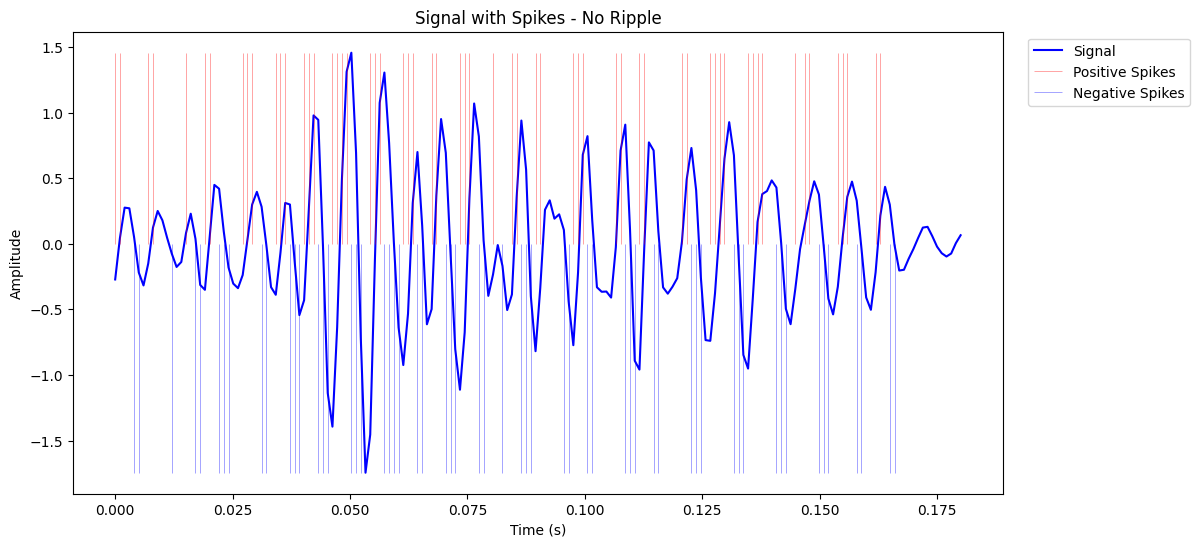

Total Spikes: 120
Up Spikes: 61
Down Spikes: 59


In [21]:
from snnTorch.utils.util import window_plot
window=0
plot_spikes=sorted_spikes[window,:,:]
plot_filtered_window=sorted_filtered_windows[window,::factor]
plot_gt=sorted_gt[window]
window_plot(plot_filtered_window,plot_spikes, plot_gt,downsampled_fs=1000,detection_window=RIPPLE_DETECTION_OFFSET)
up_spikes_window = np.sum(plot_spikes[:, 0])    # Sum along time axis
down_spikes_window = np.sum(plot_spikes[:, 1])  # Sum along time axis
print("Total Spikes:",up_spikes_window+down_spikes_window)
print("Up Spikes:",sorted_up_spikes_per_window[window])
print("Down Spikes:",sorted_down_spikes_per_window[window])

In [22]:
is_hfo = windowed_gt >= 0
hfo_windows = windowed_input_data[is_hfo]       # shape: (N_HFO, 180, 2)
non_hfo_windows = windowed_input_data[~is_hfo]  # shape: (N_nonHFO, 180, 2)

In [23]:
# Sum over time axis
hfo_up_counts = np.sum(hfo_windows[:, :, 0], axis=1)
hfo_down_counts = np.sum(hfo_windows[:, :, 1], axis=1)
total_hfo_counts = hfo_up_counts + hfo_down_counts
nonhfo_up_counts = np.sum(non_hfo_windows[:, :, 0], axis=1)
nonhfo_down_counts = np.sum(non_hfo_windows[:, :,1], axis=1)
total_nonhfo_counts = nonhfo_up_counts + nonhfo_down_counts


In [24]:
def get_isi(spike_train):
    times_up = np.where(spike_train[:,0])[0]  # spike times (e.g., indices)
    times_down = np.where(spike_train[:,0])[0]  # spike times (e.g., indices)
    times_total= np.concatenate((times_up, times_down))
    times_total.sort()  # sort the spike times
    if len(times_total) < 2:
        return np.array([])  # no ISI to compute
    return np.diff(times_total)

# Example for all HFO windows (up channel):
hfo_up_isis = [get_isi(window[:, :]) for window in hfo_windows]
nonhfo_up_isis = [get_isi(window[:, :]) for window in non_hfo_windows]

hfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in hfo_up_isis])
nonhfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in nonhfo_up_isis])


## After Undersampling Non-Ripples

In [25]:
from snnTorch.utils.training import undersample_majority, oversample_minority
intermediate_input, intermediate_gt = windowed_input_data, windowed_gt  # Default: No Balancing
balance=True
if balance:
    intermediate_input, intermediate_gt = undersample_majority(windowed_input_data, windowed_gt, GT_HFO_MASK)  

# Print the number of samples in each class
print(f"Intermediate GT Class Distribution: {np.unique(intermediate_gt, return_counts=True)}")
print(f"Intermediate Window Input Data Shape: {intermediate_input.shape}")


Intermediate GT Class Distribution: (array([-1.000e+00,  3.100e+01,  3.200e+01,  3.300e+01,  3.400e+01,  3.500e+01,  3.600e+01,
        3.700e+01,  3.800e+01,  3.900e+01,  4.000e+01,  4.100e+01,  4.200e+01,  4.300e+01,
        4.400e+01,  4.500e+01,  4.600e+01,  4.700e+01,  4.800e+01,  4.900e+01, ...,  1.710e+02,
        1.720e+02,  1.730e+02,  1.740e+02,  1.750e+02,  1.760e+02,  1.770e+02,  1.780e+02,
        1.790e+02,  1.800e+02,  5.085e+03,  5.150e+03,  5.155e+03,  5.158e+03,  5.202e+03,
        5.246e+03,  5.292e+03,  5.334e+03,  5.336e+03,  5.396e+03], dtype=float32), array([9938,   21,   25,    9,   28,    5,   18,   22,   13,   58,   35,   22,   33,   28,   23,
         52,   58,   49,   29,   72, ...,   25,   54,   13,   20,    8,    5,   13,   24,   15,
          8,    8,    8,    8,    8,    8,    8,    5,    8,    8,    8], dtype=int64))
Intermediate Window Input Data Shape: (19876, 180, 2)


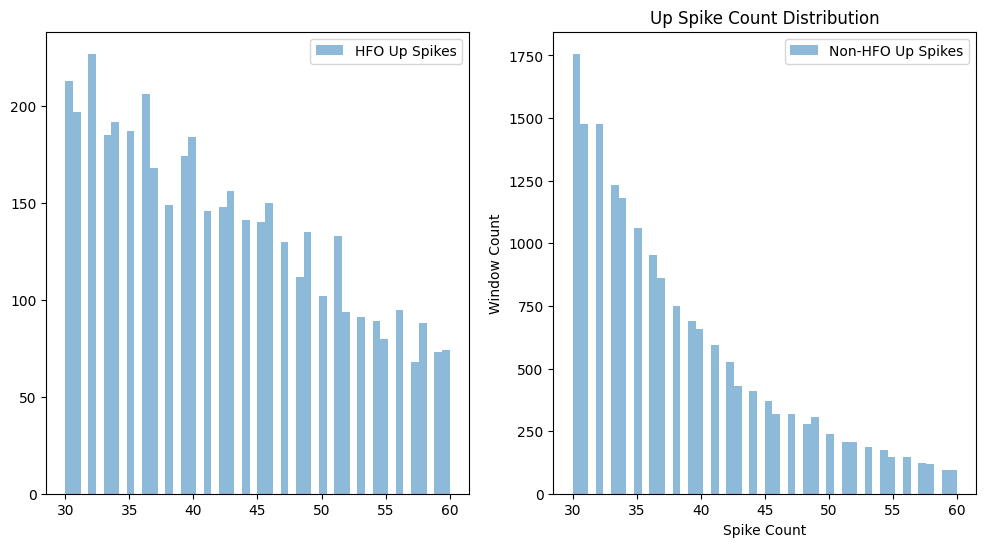

In [26]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(total_hfo_counts,range=(30,60),bins=50, alpha=0.5, label='HFO Up Spikes')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(total_nonhfo_counts, bins=50,range=(30,60), alpha=0.5, label='Non-HFO Up Spikes')
plt.legend()
plt.title('Up Spike Count Distribution')
plt.xlabel('Spike Count')
plt.ylabel('Window Count')
plt.show()

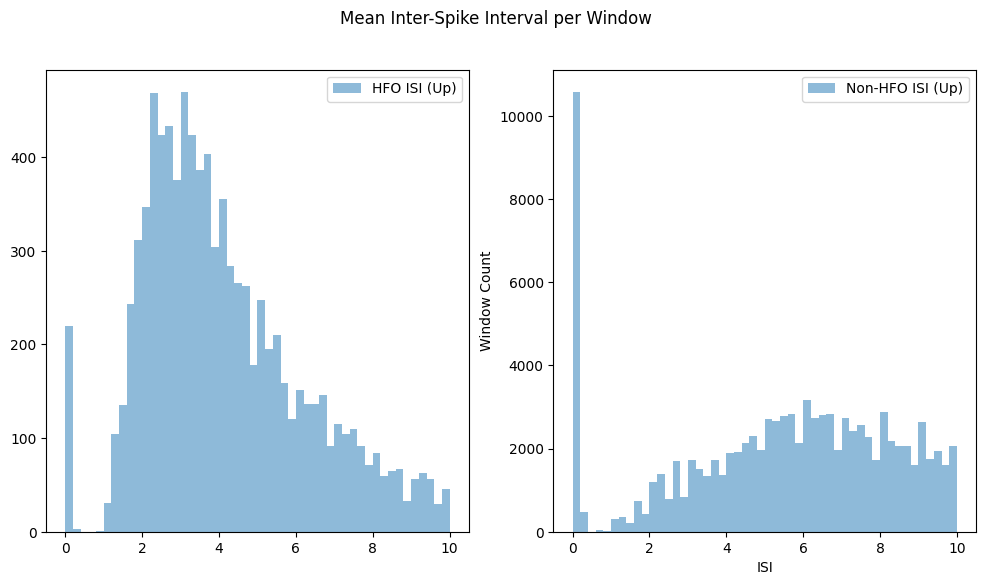

In [27]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(hfo_up_isi_mean,range=(0,10), bins=50, alpha=0.5, label='HFO ISI (Up)')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(nonhfo_up_isi_mean,range=(0,10), bins=50, alpha=0.5, label='Non-HFO ISI (Up)')
plt.legend()
plt.suptitle('Mean Inter-Spike Interval per Window')
plt.xlabel('ISI')
plt.ylabel('Window Count')
plt.show()

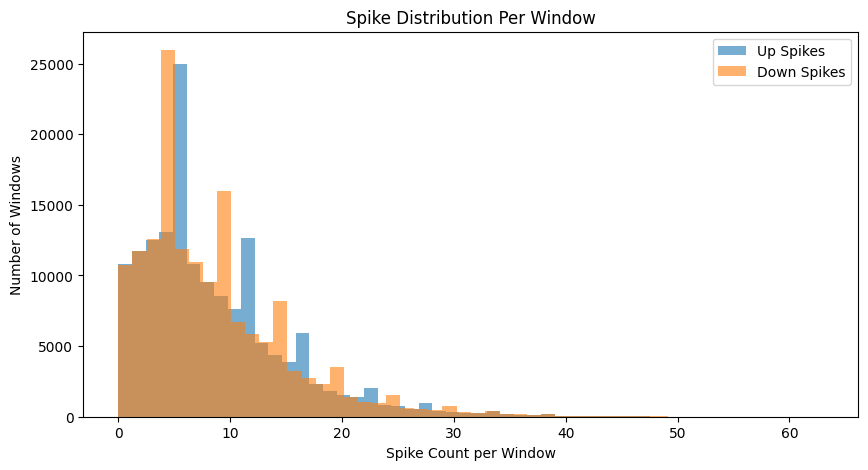

In [28]:

# Histogram of up/down spike counts
plt.figure(figsize=(10,5))
plt.hist(up_spikes_per_window, bins=50, alpha=0.6, label='Up Spikes')
plt.hist(down_spikes_per_window, bins=50, alpha=0.6, label='Down Spikes')
plt.xlabel('Spike Count per Window')
plt.ylabel('Number of Windows')
plt.title('Spike Distribution Per Window')
plt.legend()
plt.show()

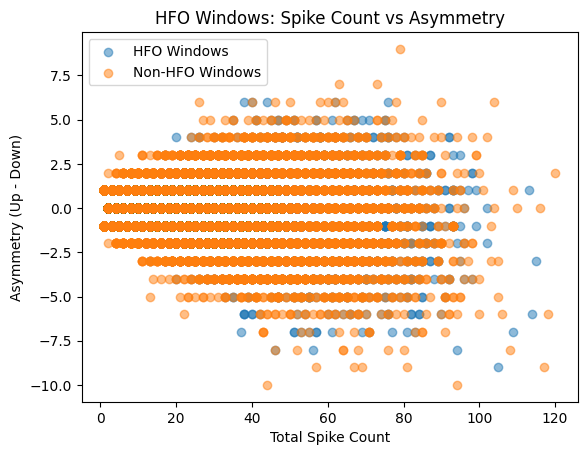

In [29]:
# Evaluate HFO windows
asymmetry_hfos = (hfo_up_counts - hfo_down_counts)
asymmetry_nonhfos = nonhfo_up_counts - nonhfo_down_counts

plt.scatter(total_hfo_counts,asymmetry_hfos , alpha=0.5, label='HFO Windows')
plt.scatter(total_nonhfo_counts,asymmetry_nonhfos, alpha=0.5, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('Asymmetry (Up - Down)')
plt.title('HFO Windows: Spike Count vs Asymmetry')
plt.legend()
plt.show()

In [30]:
is_hfo= intermediate_gt >= 0
hfo_windows = intermediate_input[is_hfo]       # shape: (N_HFO, 180, 2)
non_hfo_windows = intermediate_input[~is_hfo]  # shape: (N_nonHFO, 180, 2)

# Sum over time axis
hfo_up_counts = np.sum(hfo_windows[:, :, 0], axis=1)
hfo_down_counts = np.sum(hfo_windows[:, :, 1], axis=1)
total_hfo_counts= hfo_up_counts + hfo_down_counts
nonhfo_up_counts = np.sum(non_hfo_windows[:, :, 0], axis=1)
nonhfo_down_counts= np.sum(non_hfo_windows[:, :,1], axis=1)
total_nonhfo_counts = nonhfo_up_counts + nonhfo_down_counts

average_hfo_up_counts = np.mean(hfo_up_counts)
average_hfo_down_counts = np.mean(hfo_down_counts)
average_total_hfo_counts = np.mean(total_hfo_counts)
average_nonhfo_up_counts = np.mean(nonhfo_up_counts)
average_nonhfo_down_counts = np.mean(nonhfo_down_counts)
average_total_nonhfo_counts = np.mean(total_nonhfo_counts)
print(f"Average HFO Up Counts: {average_hfo_up_counts}")
print(f"Average HFO Down Counts: {average_hfo_down_counts}")
print(f"Average Total HFO Counts: {average_total_hfo_counts}")
print(f"Average Non-HFO Up Counts: {average_nonhfo_up_counts}")
print(f"Average Non-HFO Down Counts: {average_nonhfo_down_counts}")
print(f"Average Total Non-HFO Counts: {average_total_nonhfo_counts}")

# Example for all HFO windows (up channel):
hfo_up_isis = [get_isi(window[:, :]) for window in hfo_windows]
nonhfo_up_isis = [get_isi(window[:, :]) for window in non_hfo_windows]

hfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in hfo_up_isis])
nonhfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in nonhfo_up_isis])


Average HFO Up Counts: 16.247735962970417
Average HFO Down Counts: 16.478063996780037
Average Total HFO Counts: 32.725799959750454
Average Non-HFO Up Counts: 7.986918897162407
Average Non-HFO Down Counts: 8.040350171060576
Average Total Non-HFO Counts: 16.02726906822298


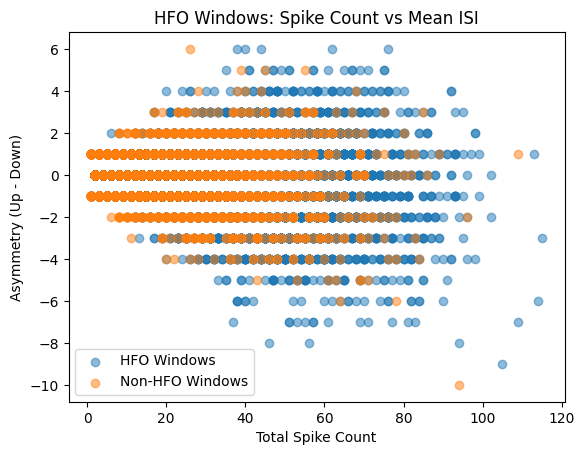

In [31]:
# Evaluate HFO windows
asymmetry_hfos = (hfo_up_counts - hfo_down_counts)
asymmetry_nonhfos = nonhfo_up_counts - nonhfo_down_counts

plt.scatter(total_hfo_counts,asymmetry_hfos , alpha=0.5, label='HFO Windows')
plt.scatter(total_nonhfo_counts,asymmetry_nonhfos, alpha=0.5, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('Asymmetry (Up - Down)')
plt.title('HFO Windows: Spike Count vs Mean ISI')
plt.legend()
plt.show()

In [ ]:
# Save the windowed 
# input data and ground truth to a file
save=True
if save:
    windowed_save=os.path.join(curr_dir,"windowed_data")
    os.makedirs(windowed_save, exist_ok=True)
    np.save(os.path.join(windowed_save, "filtered_windows.npy"), filtered_windows, allow_pickle=True)
    np.save(os.path.join(windowed_save, "windowed_input_data.npy"), windowed_input_data, allow_pickle=True)
    np.save(os.path.join(windowed_save,"windowed_gt.npy"), windowed_gt, allow_pickle=True)
    # Save the configuration to a JSON file
    with open(os.path.join(windowed_save, "config.json"), 'w') as f:
        json.dump(config, f, indent=4)